We'll write a simplifier a la Luckasz

In [38]:
import numpy as np
import sympy
import cirq
import tensorflow as tf
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt

class Solver:
    def __init__(self, n_qubits=3, qlr=0.01, qepochs=100,verbose=0, g=1, J=0):

        """"solver with n**2 possible actions: n(n-1) CNOTS + n 1-qubit unitary"""
        self.n_qubits = n_qubits
        self.qubits = cirq.GridQubit.rect(1, n_qubits)
        self.lower_bound_Eg = -2*self.n_qubits
        
        self.qlr = qlr
        self.qepochs=qepochs
        self.verbose=verbose


        self.indexed_cnots = {}
        self.cnots_index = {}
        count = 0
        for control in range(self.n_qubits):
            for target in range(self.n_qubits):
                if control != target:
                    self.indexed_cnots[str(count)] = [control, target]
                    self.cnots_index[str([control,target])] = count
                    count += 1
        self.number_of_cnots = len(self.indexed_cnots)
        
        self.final_params = []
        self.parametrized_unitary = [cirq.rz, cirq.rx, cirq.rz]
        
        self.observable=self.ising_obs(g=g, J=J)
        self.resolver = {}
        self.new_resolver = {} #this temporarly stores initialized parameters of identity resolution
        self.lowest_energy_found = -.1
        self.best_circuit_found = []
        self.best_resolver_found = {}
        
        
    def ising_obs(self, g=1, J=0):
        # -  \Gamma/2 \sum_i Z_i - J/2 \sum_{i} X_i X_{i+1}    (S_i = \Sigma_i/2; ej S_z = Z/2, S_x = X/2)
        ### analytic solution https://sci-hub.tw/https://www.sciencedirect.com/science/article/abs/pii/0003491670902708?via%3Dihub
        observable = [-float(0.5*g)*cirq.Z.on(q) for q in self.qubits] 
        for q in range(len(self.qubits)):
            observable.append(-float(0.5*J)*cirq.X.on(self.qubits[q])*cirq.X.on(self.qubits[(q+1)%len(self.qubits)]))
        #### E_0 = -\Gamma/2 \sum_k \Lambda_k , with \Lambda_k = \sqrt{ 1 + \lambda^{2}  + 2 \lambda \cos(k)}; 
        ### k = -N/2, ... , 0 ,... N/2-1 if N even
        #### k = -(N-1)/2, ... 0 , ... (N-1)/2 if N odd
        if self.n_qubits%2 == 0:
            val = -self.n_qubits/2
        else:
            val = -(self.n_qubits-1)/2
        values_q = []
        for k in range(2*self.n_qubits):
            values_q.append(val)
            val += 1/2
        ###soething wrong here.
        self.ground_energy = -(0.5*g)*np.sum(np.sqrt([1+(J/(2*g))**2 - (np.cos(2*np.pi*q/self.n_qubits)*(J/g)) for q in values_q]))
        return observable
        
    def index_meaning(self,index):
        if index<self.number_of_cnots:
            print("cnot: ",self.indexed_cnots[str(index)])
            return
        else:
            print("1-qubit unitary on: ",(index-self.number_of_cnots)%self.n_qubits)
            return

    def append_to_circuit(self, ind, circuit, params, new_index=False):
        """
        appends to circuit the index of the gate;
        and if one_hot_gate implies a rotation,
        appends to params a symbol
        """
        if ind < self.number_of_cnots:
            control, target = self.indexed_cnots[str(ind)]
            circuit.append(cirq.CNOT.on(self.qubits[control], self.qubits[target]))
            return circuit, params
        else:
            qubit = self.qubits[(ind-self.number_of_cnots)%self.n_qubits]
            for par, gate in zip(range(3),self.parametrized_unitary):
                new_param = "th_"+str(len(params))
                params.append(new_param)
                circuit.append(gate(sympy.Symbol(new_param)).on(qubit))
            return circuit, params
        
    def give_circuit(self, lista,one_hot=False):
        circuit, symbols = [], []
        for k in lista:
            circuit, symbols = self.append_to_circuit(k,circuit,symbols)
        circuit = cirq.Circuit(circuit)
        return circuit, symbols
    
    
    def resolution_2cnots(self, q1, q2):
        u1 = self.number_of_cnots + q1
        u2 = self.number_of_cnots + q2
        cnot = self.cnots_index[str([q1,q2])]
        return [cnot, u1, u2, cnot]
    
    def resolution_1qubit(self, q):
        u1 = self.number_of_cnots + q
        return [u1]
        

    def dressed_cnot(self,q1,q2):
        u1 = self.number_of_cnots + q1
        u2 = self.number_of_cnots + q2
        cnot = self.cnots_index[str([q1,q2])]
        u3 = self.number_of_cnots + q1
        u4 = self.number_of_cnots + q2
        return [u1,u2,cnot,u3,u4]
    
    def dressed_ansatz(self, layers=1):
        c=[]
        for layer in range(layers):
            qubits = list(range(self.n_qubits))
            qdeph = qubits[layers:]
            for q in qubits[:layers]:
                qdeph.append(q)
            for ind1, ind2 in zip(qubits,qdeph):
                for k in self.dressed_cnot(ind1,ind2):
                    c.append(k)
        return c


    def prepare_circuit_insertion(self,gates_index, block_to_insert, index_insertion):
        """gates_index is a vector with integer entries, each one describing a gate
            block_to_insert is block of unitaries to insert at index insertion
        """
        circuit = cirq.Circuit()
        idx_circuit=[]
        symbols = []
        new_symbols = []
        new_resolver = {}

        for ind, g in enumerate(gates_index):
            #### insert new block ####
            if ind == insertion_index:
                for gate in block_to_insert:
                    idx_circuit.append(gate)
                    if gate < self.number_of_cnots:
                        control, target = self.indexed_cnots[str(gate)]
                        circuit.append(cirq.CNOT.on(self.qubits[control], self.qubits[target]))
                    else:
                        qubit = self.qubits[(gate-self.number_of_cnots)%self.n_qubits]
                        for par, gateblack in zip(range(3),self.parametrized_unitary):
                            new_symbol = "New_th_"+str(len(new_symbols))
                            new_symbols.append(new_symbol)
                            new_resolver[new_symbol] = np.random.uniform(-.1,.1) #rotation around epsilon... we can do it better afterwards
                            circuit.append(gateblack(sympy.Symbol(new_symbol)).on(qubit))
            if g < self.number_of_cnots:
                idx_circuit.append(g)
                control, target = self.indexed_cnots[str(g)]
                circuit.append(cirq.CNOT.on(self.qubits[control], self.qubits[target]))
            else:
                idx_circuit.append(g)
                qubit = self.qubits[(ind-self.number_of_cnots)%self.n_qubits]
                for par, gate in zip(range(3),self.parametrized_unitary):
                    new_symbol = "th_"+str(len(symbols))
                    symbols.append(new_symbol)
                    circuit.append(gate(sympy.Symbol(new_symbol)).on(qubit))
                    if not new_symbol in self.resolver.keys(): #this is in case it's the first time. Careful when deleting !
                        self.resolver[new_symbol] = np.random.uniform(-np.pi, np.pi)

        ### add identity for TFQ tocompute correctily expected value####
        effective_qubits = list(circuit.all_qubits())
        for k in self.qubits:
            if k not in effective_qubits:
                circuit.append(cirq.I.on(k))
        self.new_resolver = new_resolver
        #self.current_circuit = idx_circuit ### store the new indexed circuit (whose resolver is obtained from both self.new_resolver and self.resolver)
        variables = [symbols, new_symbols]
        return circuit, variables#, idx_circuit
    
    
    
    def TFQ_model(self, symbols):
        circuit_input = tf.keras.Input(shape=(), dtype=tf.string)
        output = tfq.layers.Expectation()(
                circuit_input,
                symbol_names=symbols,
                operators=tfq.convert_to_tensor([self.observable]),
                initializer=tf.keras.initializers.RandomNormal()) #we may change this!!!

        model = tf.keras.Model(inputs=circuit_input, outputs=output)
        adam = tf.keras.optimizers.Adam(learning_rate=self.qlr)
        model.compile(optimizer=adam, loss='mse')
        return model
    
    def initialize_model_insertion(self, variables):
        ### initialize model with parameters from previous model (describer by variables[0]) --> values in self.resolver
        ###(for the already-optimized ones), and close to identity for the block added, described by variables[1], whose values are in self.new_resolver

        symbols, new_symbols = variables
        circuit_symbols = []
        init_params = []
        for j in symbols:
            circuit_symbols.append(j)
            init_params.append(self.resolver[str(j)])#+ np.random.uniform(-.01,.01)) if you want to perturbate previous parameters..
        for k in new_symbols:
            circuit_symbols.append(k)
            init_params.append(self.new_resolver[str(k)])

        model = self.TFQ_model(circuit_symbols)
        model.trainable_variables[0].assign(tf.convert_to_tensor(init_params)) #initialize parameters of model (continuous parameters of uniraries)
        #with the corresponding values
        return model

    def run_circuit_from_index(self, gates_index):
        """
        takes as input vector with actions described as integer
        and outputsthe energy of that circuit (w.r.t self.observable)
        """
        ### create a vector with the gates on the corresponding qubit(s)
        circuit, symbols = self.give_circuit(gates_index)
        
        ### this is because each qubit should be "activated" in TFQ to do the optimization (if the observable has support on this qubit as well and you don't add I then error)
        effective_qubits = list(circuit.all_qubits())
        for k in self.qubits:
            if k not in effective_qubits:
                circuit.append(cirq.I.on(k))

        tfqcircuit = tfq.convert_to_tensor([circuit])
        if len(symbols) == 0:
            expval = tfq.layers.Expectation()(
                                            tfqcircuit,
                                            operators=tfq.convert_to_tensor([self.observable]))
            energy = np.float32(np.squeeze(tf.math.reduce_sum(expval, axis=-1, keepdims=True)))
            final_params = []
            resolver = {"th_"+str(ind):var  for ind,var in enumerate(final_params)}
        else:
            model = self.TFQ_model(symbols)
            qoutput = tf.ones((1, 1))*self.lower_bound_Eg
            model.fit(x=tfqcircuit, y=qoutput, batch_size=1, epochs=self.qepochs, verbose=self.verbose)
            energy = np.squeeze(tf.math.reduce_sum(model.predict(tfqcircuit), axis=-1))
            final_params = model.trainable_variables[0].numpy()
            resolver = {"th_"+str(ind):var  for ind,var in enumerate(final_params)}
        return gates_index, resolver, energy
    
    
    def accept_modification(self, energy):
        return energy < self.lowest_energy_found# or np.random.random() >.9# accept a bad one with some probability a la metropolis (maybe use \delta E)
    
    
    def optimize_and_update(self, model, circuit,variables,insertion_index_loaded):
        #### fit continuous parameters ###
        
        k=0
        for ind,gh in enumerate(list(circuit.all_operations())):
            if gh.gate == cirq.I:
                k+=1
        if ind == k-1:
            return self.current_circuit, self.resolver, self.lowest_energy_found
            
        tfqcircuit = tfq.convert_to_tensor([circuit])
        qoutput = tf.ones((1, 1))*self.lower_bound_Eg
        model.fit(x=tfqcircuit, y=qoutput, batch_size=1, epochs=self.qepochs, verbose=0)
        energy = np.squeeze(tf.math.reduce_sum(model.predict(tfqcircuit), axis=-1))

        if self.accept_modification(energy):
            self.lowest_energy_found = energy
            
            #### if we accept the new configuration, then we update the resolver merging both symbols and new_symbols into self.resolver
            symbols, new_symbols = variables

            for ind,k in enumerate(symbols):
                self.resolver[k] = model.trainable_variables[0].numpy()[ind]

            for indnew,knew in enumerate(new_symbols):
                self.new_resolver[knew] = model.trainable_variables[0].numpy()[len(symbols)+indnew]

            final_symbols = []
            old_solver = []
            old_added = []

            final_resolver = {}
            new_circuit = []
            for ind, g in enumerate(self.current_circuit): #self.current_circuit is associated with symbols and current self.resolver
                
                #### insert new block ####
                if ind == insertion_index_loaded:
                    for gate in block_to_insert:
                        new_circuit.append(gate)
                        if gate < sol.number_of_cnots:
                            pass
                        else:
                            for par, gateblock in zip(range(3),sol.parametrized_unitary):

                                var1 = "New_th_"+str(len(old_added))
                                old_added.append(var1)

                                var2 = "th_"+str(len(final_symbols))
                                final_symbols.append(var2)
                                final_resolver[var2] = self.new_resolver[var1] #

                if g < self.number_of_cnots:
                    new_circuit.append(g)
                    pass
                else:
                    new_circuit.append(g)
                    for par, gate in zip(range(3),self.parametrized_unitary):
                        var3 = "th_"+str(len(old_solver))
                        old_solver.append(var3)

                        var4 = "th_"+str(len(final_symbols))
                        final_symbols.append(var4)
                        final_resolver[var4] = self.resolver[var3] 

            self.resolver = final_resolver
            self.current_circuit = new_circuit #### now the current circuit is the better one! :
            self.best_circuit_found = new_circuit
            self.best_resolver_found = resolver
            return new_circuit, self.resolver, energy
        else:
            return self.current_circuit, self.resolver, self.lowest_energy_found
    
    def kill_one_unitary(self, gates_index, resolver, energy):
        """
        this function takes circuit as described by gates_index (sequence of integers)
        and returns when possible, a circuit, resolver, energy with one single-qubit unitary less.
        """
        if energy == 0.:
            energy = 10**-12

        circuit_proposals=[] #storing all good candidates.
        
        for j in gates_index:
            indexed_prop=[]

            prop=cirq.Circuit()
            checking = False
            ko=0
            to_pop=[]

            for k in gates_index:
                if k < self.number_of_cnots:
                    indexed_prop.append(k)
                    control, target = self.indexed_cnots[str(k)]
                    prop.append(cirq.CNOT.on(self.qubits[control], self.qubits[target]))
                else:
                    if k != j:
                        indexed_prop.append(k)
                        qubit = self.qubits[(k-self.number_of_cnots)%self.n_qubits]
                        for par, gate in zip(range(3),self.parametrized_unitary):
                            new_param = "th_"+str(ko)
                            ko+=1
                            prop.append(gate(sympy.Symbol(new_param)).on(qubit))
                    else:
                        checking=True
                        for i in range(3):
                            to_pop.append("th_"+str(ko))
                            ko+=1
            if checking is True:
                nr = resolver.copy()
                for p in to_pop:
                    nr.pop(p)  
                
                effective_qubits = list(prop.all_qubits())
                for k in self.qubits:
                    if k not in effective_qubits:
                        prop.append(cirq.I.on(k))
                
                tfqcircuit = tfq.convert_to_tensor([cirq.resolve_parameters(prop, nr)]) ###resolver parameters !!!
                expval = tfq.layers.Expectation()(
                                        tfqcircuit,
                                        operators=tfq.convert_to_tensor([self.observable]))
                new_energy = np.float32(np.squeeze(tf.math.reduce_sum(expval, axis=-1, keepdims=True)))

                if self.accept_modification(new_energy):
                    ordered_resolver = {}
                    for ind,k in enumerate(nr.values()):
                        ordered_resolver["th_"+str(ind)] = k
                    circuit_proposals.append([indexed_prop,ordered_resolver,new_energy])
        if len(circuit_proposals)>0:
            favourite = np.random.choice(len(circuit_proposals))
            short_circuit, resolver, energy = circuit_proposals[favourite]
            self.current_circuit = short_circuit
            self.resolver = resolver
            
            ### save shortest..
            self.best_resolver_found = resolver
            self.best_circuit_found = short_circuit
            simplified=True
            return short_circuit, resolver, energy, simplified
        else:
            simplified=False
            return gates_index, resolver, energy, simplified

    
    def simplify_circuit(self,indexed_circuit):
        """this function kills repeated unitaries and 
        CNOTS and returns a simplified indexed_circuit vector"""
        #load circuit on each qubit
        connections={str(q):[] for q in range(self.n_qubits)} #this saves the gates in each qubit
        places_gates = {str(q):[] for q in range(self.n_qubits)} #this saves, for each gate on each qubit, the position in the original indexed_circuit


        flagged = [False]*len(indexed_circuit) #to check if you have seen a cnot already, so not to append it twice to the qubit's dictionary

        for q in range(self.n_qubits): #sweep over all qubits
            for nn,idq in enumerate(indexed_circuit): #sweep over all gates in original circuit's vector
                if idq<self.number_of_cnots: #if the gate it's a CNOT or not
                    control, target = self.indexed_cnots[str(idq)] #give control and target qubit
                    if q in [control, target] and not flagged[nn]: #if the qubit we are looking at is affected by this CNOT, and we haven't add this CNOT to the dictionary yet
                        connections[str(control)].append(idq)
                        connections[str(target)].append(idq)
                        places_gates[str(control)].append(nn)
                        places_gates[str(target)].append(nn)
                        flagged[nn] = True #so you don't add the other
                else:
                    if idq%self.n_qubits == q: #check if the unitary is applied to the qubit we are looking at
                        connections[str(q)].append("u")
                        places_gates[str(q)].append(nn)


        ### now reducing the circuit
        new_indexed_circuit = indexed_circuit.copy()
        for q, path in connections.items(): ###sweep over qubits: path is all the gates that act this qubit during the circuit
            for ind,gate in enumerate(path):
                if gate == "u": ## IF GATE IS SINGLE QUIT UNITARY, CHECK IF THE NEXT ONES ARE ALSO UNITARIES AND KILL 'EM
                    for k in range(len(path)-ind-1):
                        if path[ind+k+1]=="u":
                            new_indexed_circuit[places_gates[str(q)][ind+k+1]] = -1
                        else:
                            break
                elif gate in range(self.number_of_cnots) and ind<len(path)-1: ### self.number_of_cnots is the maximum index of a CNOT gate for a fixed self.n_qubits.
                    if path[ind+1]==gate and not (new_indexed_circuit[places_gates[str(q)][ind]] == -1): #check if the next gate is the same CNOT; and check if I haven't corrected the original one (otherwise you may simplify 3 CNOTs to id)
                        others = self.indexed_cnots[str(gate)].copy()
                        others.remove(int(q)) #the other qubit affected by the CNOT
                        for jind, jgate in enumerate(connections[str(others[0])][:-1]): ##sweep the other qubit's gates until i find "gate"
                            if jgate == gate and connections[str(others[0])][jind+1] == gate: ##i find the same gate that is repeated in both the original qubit and this one
                                if (places_gates[str(q)][ind] == places_gates[str(others[0])][jind]) and (places_gates[str(q)][ind+1] == places_gates[str(others[0])][jind+1]): #check that positions in the indexed_circuit are the same
                                 ###maybe I changed before, so I have repeated in the original but one was shut down..
                                    new_indexed_circuit[places_gates[str(q)][ind]] = -1 ###just kill the repeated CNOTS
                                    new_indexed_circuit[places_gates[str(q)][ind+1]] = -1 ###just kill the repeated CNOTS
                                    break
                                    
                if gate in range(self.number_of_cnots) and ind == 0: ###if I have a CNOT just before initializing, it does nothing (if |0> initialization).
                    others = self.indexed_cnots[str(gate)].copy()
                    others.remove(int(q)) #the other qubit affected by the CNOT
                    for jind, jgate in enumerate(connections[str(others[0])][:-1]): ##sweep the other qubit's gates until i find "gate"
                        if jgate == gate and jind==0: ##it's also the first gate in the other qubit
                            if (places_gates[str(q)][ind] == places_gates[str(others[0])][jind]): #check that positions in the indexed_circuit are the same
                                new_indexed_circuit[places_gates[str(q)][ind]] = -1 ###just kill the repeated CNOTS
                                break
                    
        #### remove the marked indices ###### 
        #### remove the marked indices ######            
        
        final=[]
        for gmarked in new_indexed_circuit:
            if not gmarked == -1:
                final.append(gmarked)
        return final
    
    def count_number_cnots(self, gates_index):
        c=0
        for k in gates_index:
            if k<self.number_of_cnots:
                c+=1
        return c

In [65]:
sols = {}
for j in tqdm(np.arange(.01,2.1,.1)):

    sol = Solver(n_qubits= 3, qlr=0.1, qepochs=100, g=1, J=j)
    history_energies=[]
    best_energies_found = []

    gates_index = [sol.number_of_cnots] ## begin with a certain circuit
    gates_index, resolver, energy= sol.run_circuit_from_index(gates_index)
    sol.current_circuit = gates_index

    cnots_number = []
    for k in range(15):

        which_block = np.random.choice([0,1], p=[.5,.5])
        if which_block == 0:
            qubit = np.random.choice(sol.n_qubits)
            block_to_insert = sol.resolution_1qubit(qubit)
        else:
            qubits = np.random.choice(sol.n_qubits, 2,replace = False)
            block_to_insert = sol.resolution_2cnots(qubits[0], qubits[1])
            insertion_index = np.random.choice(max(1,len(gates_index))) #gives index between \in [0, len(gates_index) )

        ### optimize the circuit with the block appended. This is tricky since we initialize
        ###  the continuous parameters with the older ones, and the "block ones" close to identity
        circuit, variables = sol.prepare_circuit_insertion(gates_index, block_to_insert, insertion_index)
        model = sol.initialize_model_insertion(variables) ### initialize the model in the previously optimized parameters & resolution to identity for the block

        gates_index, resolver, energy = sol.optimize_and_update(model, circuit, variables, insertion_index) #inside, if better circuit is found, saves it.
        s=0
        for k in range(50):
            gates_index, resolver, energy, simplified =  sol.kill_one_unitary(gates_index, resolver, energy)
            if simplified is False:
                s+=-1
            else:
                s+=1
            if s<-15:
                break

        ### now I simplify the circuit and if the length is changed I run the optimization again
        simplified_gates_index = sol.simplify_circuit(gates_index)
        if len(simplified_gates_index)<len(gates_index):
            gates_index, resolver, energy = sol.run_circuit_from_index(simplified_gates_index)
            sol.current_circuit = gates_index
            sol.resolver = resolver
            #sol.best_cnots_number.append(sol.count_cnots_number(gates_index))
        sol.new_resolver = {}
        history_energies.append(energy)
        best_energies_found.append(sol.lowest_energy_found)

        print("energy: ", energy, "... j", j)
    sols[str(j)] = sol

  0%|          | 0/21 [00:00<?, ?it/s]

energy:  -1.5000043 ... j 0.01
energy:  -1.5000122 ... j 0.01
energy:  -1.5000117 ... j 0.01
energy:  -1.5000117 ... j 0.01
energy:  -1.5000117 ... j 0.01
energy:  -1.5000061 ... j 0.01
energy:  -1.5000123 ... j 0.01
energy:  -1.4999918 ... j 0.01
energy:  -1.5000203 ... j 0.01
energy:  -1.5000203 ... j 0.01
energy:  -1.5000203 ... j 0.01
energy:  -1.5000203 ... j 0.01
energy:  -1.5000203 ... j 0.01
energy:  -1.5000203 ... j 0.01


  5%|▍         | 1/21 [00:37<12:37, 37.88s/it]

energy:  -1.5000203 ... j 0.01
energy:  -1.5014957 ... j 0.11
energy:  -1.5014957 ... j 0.11
energy:  -1.5014957 ... j 0.11
energy:  -1.5014966 ... j 0.11
energy:  -1.5031654 ... j 0.11
energy:  -1.5031701 ... j 0.11
energy:  -1.5031637 ... j 0.11
energy:  -1.5031637 ... j 0.11
energy:  -1.5031637 ... j 0.11
energy:  -1.5031637 ... j 0.11
energy:  -1.5031637 ... j 0.11
energy:  -1.5031637 ... j 0.11
energy:  -1.5031637 ... j 0.11
energy:  -1.504733 ... j 0.11


 10%|▉         | 2/21 [01:19<12:18, 38.88s/it]

energy:  -1.504733 ... j 0.11
energy:  -1.5 ... j 0.21000000000000002
energy:  -1.4999895 ... j 0.21000000000000002
energy:  -1.4999895 ... j 0.21000000000000002
energy:  -1.4999895 ... j 0.21000000000000002
energy:  -1.4999895 ... j 0.21000000000000002
energy:  -1.4999895 ... j 0.21000000000000002
energy:  -1.4999895 ... j 0.21000000000000002
energy:  -1.4999895 ... j 0.21000000000000002
energy:  -1.4999895 ... j 0.21000000000000002
energy:  -1.4999895 ... j 0.21000000000000002
energy:  -1.4999895 ... j 0.21000000000000002
energy:  -1.4999895 ... j 0.21000000000000002
energy:  -1.4999895 ... j 0.21000000000000002


 14%|█▍        | 3/21 [01:21<08:23, 27.96s/it]

energy:  -1.4999895 ... j 0.21000000000000002
energy:  -1.4999895 ... j 0.21000000000000002
energy:  -1.5118401 ... j 0.31000000000000005
energy:  -1.5118577 ... j 0.31000000000000005
energy:  -1.5118577 ... j 0.31000000000000005
energy:  -1.5118577 ... j 0.31000000000000005
energy:  -1.5118486 ... j 0.31000000000000005
energy:  -1.5118595 ... j 0.31000000000000005
energy:  -1.5409278 ... j 0.31000000000000005
energy:  -1.5412132 ... j 0.31000000000000005
energy:  -1.5412682 ... j 0.31000000000000005
energy:  -1.541282 ... j 0.31000000000000005
energy:  -1.541282 ... j 0.31000000000000005
energy:  -1.541282 ... j 0.31000000000000005
energy:  -1.541282 ... j 0.31000000000000005
energy:  -1.541282 ... j 0.31000000000000005


 19%|█▉        | 4/21 [02:06<09:23, 33.12s/it]

energy:  -1.541282 ... j 0.31000000000000005
energy:  -1.5 ... j 0.41000000000000003
energy:  -1.5 ... j 0.41000000000000003
energy:  -1.5 ... j 0.41000000000000003
energy:  -1.520675 ... j 0.41000000000000003
energy:  -1.520659 ... j 0.41000000000000003
energy:  -1.5518456 ... j 0.41000000000000003
energy:  -1.5518454 ... j 0.41000000000000003
energy:  -1.5518454 ... j 0.41000000000000003
energy:  -1.5518454 ... j 0.41000000000000003
energy:  -1.5518454 ... j 0.41000000000000003
energy:  -1.5518454 ... j 0.41000000000000003
energy:  -1.5518454 ... j 0.41000000000000003
energy:  -1.5518454 ... j 0.41000000000000003
energy:  -1.5751547 ... j 0.41000000000000003


 24%|██▍       | 5/21 [02:35<08:31, 31.94s/it]

energy:  -1.575202 ... j 0.41000000000000003
energy:  -1.5318383 ... j 0.51
energy:  -1.5317969 ... j 0.51
energy:  -1.5317969 ... j 0.51
energy:  -1.5318187 ... j 0.51
energy:  -1.5318413 ... j 0.51
energy:  -1.5318413 ... j 0.51
energy:  -1.5318413 ... j 0.51
energy:  -1.5318413 ... j 0.51
energy:  -1.5318413 ... j 0.51
energy:  -1.5318413 ... j 0.51
energy:  -1.5318413 ... j 0.51
energy:  -1.5318413 ... j 0.51
energy:  -1.5318413 ... j 0.51
energy:  -1.5318413 ... j 0.51


 29%|██▊       | 6/21 [02:57<07:13, 28.90s/it]

energy:  -1.5318413 ... j 0.51
energy:  -1.5452645 ... j 0.6100000000000001
energy:  -1.5453395 ... j 0.6100000000000001
energy:  -1.5453395 ... j 0.6100000000000001
energy:  -1.5453395 ... j 0.6100000000000001
energy:  -1.6285498 ... j 0.6100000000000001
energy:  -1.6286851 ... j 0.6100000000000001
energy:  -1.6287029 ... j 0.6100000000000001
energy:  -1.6287029 ... j 0.6100000000000001
energy:  -1.6287029 ... j 0.6100000000000001
energy:  -1.6287029 ... j 0.6100000000000001
energy:  -1.6287061 ... j 0.6100000000000001
energy:  -1.628604 ... j 0.6100000000000001
energy:  -1.6287352 ... j 0.6100000000000001
energy:  -1.6287352 ... j 0.6100000000000001


 33%|███▎      | 7/21 [03:51<08:27, 36.28s/it]

energy:  -1.6286924 ... j 0.6100000000000001
energy:  -1.5 ... j 0.7100000000000001
energy:  -1.4999893 ... j 0.7100000000000001
energy:  -1.4999893 ... j 0.7100000000000001
energy:  -1.4999893 ... j 0.7100000000000001
energy:  -1.4999893 ... j 0.7100000000000001
energy:  -1.4999893 ... j 0.7100000000000001
energy:  -1.4999893 ... j 0.7100000000000001
energy:  -1.4999893 ... j 0.7100000000000001
energy:  -1.4999893 ... j 0.7100000000000001
energy:  -1.4999893 ... j 0.7100000000000001
energy:  -1.4999893 ... j 0.7100000000000001
energy:  -1.4999893 ... j 0.7100000000000001
energy:  -1.4999893 ... j 0.7100000000000001
energy:  -1.4999893 ... j 0.7100000000000001


 38%|███▊      | 8/21 [03:53<05:39, 26.14s/it]

energy:  -1.4999893 ... j 0.7100000000000001
energy:  -1.5000002 ... j 0.81
energy:  -1.6043473 ... j 0.81
energy:  -1.6897875 ... j 0.81
energy:  -1.6897875 ... j 0.81
energy:  -1.677931 ... j 0.81
energy:  -1.677931 ... j 0.81
energy:  -1.677931 ... j 0.81
energy:  -1.677931 ... j 0.81
energy:  -1.677931 ... j 0.81
energy:  -1.5787048 ... j 0.81
energy:  -1.7522261 ... j 0.81
energy:  -1.7521169 ... j 0.81
energy:  -1.6415904 ... j 0.81
energy:  -1.7929858 ... j 0.81


 43%|████▎     | 9/21 [04:50<07:04, 35.35s/it]

energy:  -1.7929858 ... j 0.81
energy:  -1.59852 ... j 0.91
energy:  -1.5984923 ... j 0.91
energy:  -1.6904706 ... j 0.91
energy:  -1.6904706 ... j 0.91
energy:  -1.6904706 ... j 0.91
energy:  -1.6904706 ... j 0.91
energy:  -1.6904706 ... j 0.91
energy:  -1.6904706 ... j 0.91
energy:  -1.6904706 ... j 0.91
energy:  -1.6904706 ... j 0.91
energy:  -1.6904706 ... j 0.91
energy:  -1.6904706 ... j 0.91
energy:  -1.6904706 ... j 0.91
energy:  -1.6904706 ... j 0.91


 48%|████▊     | 10/21 [05:21<06:15, 34.15s/it]

energy:  -1.6904706 ... j 0.91
energy:  -1.5 ... j 1.01
energy:  -1.4999943 ... j 1.01
energy:  -1.4999943 ... j 1.01
energy:  -1.4999943 ... j 1.01
energy:  -1.4999943 ... j 1.01
energy:  -1.4999943 ... j 1.01
energy:  -1.4999943 ... j 1.01
energy:  -1.4999943 ... j 1.01
energy:  -1.4999943 ... j 1.01
energy:  -1.4999943 ... j 1.01
energy:  -1.4999943 ... j 1.01
energy:  -1.4999943 ... j 1.01
energy:  -1.4999943 ... j 1.01
energy:  -1.4999943 ... j 1.01


 52%|█████▏    | 11/21 [05:24<04:05, 24.55s/it]

energy:  -1.4999943 ... j 1.01
energy:  -1.6436121 ... j 1.11
energy:  -1.6436228 ... j 1.11
energy:  -2.025188 ... j 1.11
energy:  -2.025191 ... j 1.11
energy:  -2.088687 ... j 1.11
energy:  -2.088687 ... j 1.11
energy:  -2.088687 ... j 1.11
energy:  -2.088687 ... j 1.11
energy:  -2.088687 ... j 1.11
energy:  -2.088687 ... j 1.11
energy:  -2.088687 ... j 1.11
energy:  -2.088687 ... j 1.11
energy:  -2.088687 ... j 1.11
energy:  -2.088687 ... j 1.11


 57%|█████▋    | 12/21 [06:20<05:08, 34.25s/it]

energy:  -2.088687 ... j 1.11
energy:  -1.6687062 ... j 1.2100000000000002
energy:  -1.6686425 ... j 1.2100000000000002
energy:  -1.6687459 ... j 1.2100000000000002
energy:  -1.6687459 ... j 1.2100000000000002
energy:  -2.134998 ... j 1.2100000000000002
energy:  -2.135102 ... j 1.2100000000000002
energy:  -2.2215908 ... j 1.2100000000000002
energy:  -2.2242944 ... j 1.2100000000000002
energy:  -2.2245877 ... j 1.2100000000000002
energy:  -2.2245877 ... j 1.2100000000000002
energy:  -2.2245877 ... j 1.2100000000000002
energy:  -2.2245877 ... j 1.2100000000000002
energy:  -2.2245877 ... j 1.2100000000000002
energy:  -2.2245877 ... j 1.2100000000000002


 62%|██████▏   | 13/21 [07:27<05:52, 44.02s/it]

energy:  -2.2245877 ... j 1.2100000000000002
energy:  -1.5 ... j 1.31
energy:  -1.4999986 ... j 1.31
energy:  -1.4999986 ... j 1.31
energy:  -1.4999986 ... j 1.31
energy:  -1.4999986 ... j 1.31
energy:  -1.4999986 ... j 1.31
energy:  -1.4999986 ... j 1.31
energy:  -1.4999986 ... j 1.31
energy:  -1.4999986 ... j 1.31
energy:  -1.4999986 ... j 1.31


 67%|██████▋   | 14/21 [07:30<03:40, 31.55s/it]

energy:  -1.4999986 ... j 1.31
energy:  -1.4999986 ... j 1.31
energy:  -1.4999986 ... j 1.31
energy:  -1.4999986 ... j 1.31
energy:  -1.4999986 ... j 1.31
energy:  -1.7235248 ... j 1.4100000000000001
energy:  -2.3003674 ... j 1.4100000000000001
energy:  -2.3810244 ... j 1.4100000000000001
energy:  -2.3820806 ... j 1.4100000000000001
energy:  -2.3820252 ... j 1.4100000000000001
energy:  -2.3820252 ... j 1.4100000000000001
energy:  -2.3797657 ... j 1.4100000000000001
energy:  -2.3821301 ... j 1.4100000000000001
energy:  -2.3835657 ... j 1.4100000000000001
energy:  -2.394948 ... j 1.4100000000000001
energy:  -2.394948 ... j 1.4100000000000001
energy:  -2.394948 ... j 1.4100000000000001
energy:  -2.3860343 ... j 1.4100000000000001
energy:  -2.459811 ... j 1.4100000000000001


 71%|███████▏  | 15/21 [08:23<03:48, 38.04s/it]

energy:  -2.3864408 ... j 1.4100000000000001
energy:  -2.43392 ... j 1.51
energy:  -2.4362428 ... j 1.51
energy:  -1.7726269 ... j 1.51
energy:  -2.437416 ... j 1.51
energy:  -2.4992375 ... j 1.51
energy:  -2.499535 ... j 1.51
energy:  -2.499535 ... j 1.51
energy:  -2.499535 ... j 1.51
energy:  -2.499535 ... j 1.51
energy:  -2.5837402 ... j 1.51
energy:  -2.5837598 ... j 1.51
energy:  -2.5837598 ... j 1.51
energy:  -2.5837598 ... j 1.51
energy:  -2.5837598 ... j 1.51


 76%|███████▌  | 16/21 [09:02<03:12, 38.48s/it]

energy:  -2.5837598 ... j 1.51
energy:  -1.5 ... j 1.61
energy:  -1.4999924 ... j 1.61
energy:  -1.4999924 ... j 1.61
energy:  -1.4999924 ... j 1.61
energy:  -1.4999924 ... j 1.61
energy:  -1.4999924 ... j 1.61
energy:  -1.4999924 ... j 1.61
energy:  -1.4999924 ... j 1.61
energy:  -1.4999924 ... j 1.61
energy:  -1.4999924 ... j 1.61
energy:  -1.4999924 ... j 1.61
energy:  -1.4999924 ... j 1.61
energy:  -1.4999924 ... j 1.61
energy:  -1.4999924 ... j 1.61


 81%|████████  | 17/21 [09:05<01:50, 27.57s/it]

energy:  -1.4999924 ... j 1.61
energy:  -1.8155172 ... j 1.7100000000000002
energy:  -1.8155296 ... j 1.7100000000000002
energy:  -1.8155296 ... j 1.7100000000000002
energy:  -1.815556 ... j 1.7100000000000002
energy:  -2.7826166 ... j 1.7100000000000002
energy:  -2.7826166 ... j 1.7100000000000002
energy:  -2.7826166 ... j 1.7100000000000002
energy:  -2.7826166 ... j 1.7100000000000002
energy:  -2.714466 ... j 1.7100000000000002
energy:  -2.7839873 ... j 1.7100000000000002
energy:  -2.7839873 ... j 1.7100000000000002
energy:  -2.7128654 ... j 1.7100000000000002
energy:  -1.815607 ... j 1.7100000000000002
energy:  -2.785042 ... j 1.7100000000000002


 86%|████████▌ | 18/21 [09:46<01:35, 31.80s/it]

energy:  -2.787738 ... j 1.7100000000000002
energy:  -2.8532727 ... j 1.81
energy:  -2.8544025 ... j 1.81
energy:  -2.8964741 ... j 1.81
energy:  -2.8964741 ... j 1.81
energy:  -2.8964741 ... j 1.81
energy:  -2.9202619 ... j 1.81
energy:  -2.9208715 ... j 1.81
energy:  -2.9214056 ... j 1.81
energy:  -2.9211602 ... j 1.81
energy:  -2.9211602 ... j 1.81
energy:  -2.9207 ... j 1.81
energy:  -2.9349835 ... j 1.81
energy:  -2.9720788 ... j 1.81
energy:  -2.9720788 ... j 1.81


 90%|█████████ | 19/21 [10:38<01:15, 37.91s/it]

energy:  -2.9720788 ... j 1.81
energy:  -1.8823726 ... j 1.9100000000000001
energy:  -2.9940157 ... j 1.9100000000000001
energy:  -3.0583725 ... j 1.9100000000000001
energy:  -2.9973135 ... j 1.9100000000000001
energy:  -3.0599647 ... j 1.9100000000000001
energy:  -3.0593762 ... j 1.9100000000000001
energy:  -3.060374 ... j 1.9100000000000001
energy:  -3.0383456 ... j 1.9100000000000001
energy:  -3.0606995 ... j 1.9100000000000001
energy:  -3.0606995 ... j 1.9100000000000001
energy:  -3.1055803 ... j 1.9100000000000001
energy:  -3.1046906 ... j 1.9100000000000001
energy:  -3.1055279 ... j 1.9100000000000001
energy:  -3.1048894 ... j 1.9100000000000001


 95%|█████████▌| 20/21 [12:11<00:54, 54.37s/it]

energy:  -3.1048894 ... j 1.9100000000000001
energy:  -1.5 ... j 2.01
energy:  -1.4999967 ... j 2.01
energy:  -1.4999967 ... j 2.01
energy:  -1.4999967 ... j 2.01
energy:  -1.4999967 ... j 2.01
energy:  -1.4999967 ... j 2.01
energy:  -1.4999967 ... j 2.01
energy:  -1.4999967 ... j 2.01
energy:  -1.4999967 ... j 2.01
energy:  -1.4999967 ... j 2.01
energy:  -1.4999967 ... j 2.01
energy:  -1.4999967 ... j 2.01
energy:  -1.4999967 ... j 2.01
energy:  -1.4999967 ... j 2.01


100%|██████████| 21/21 [12:13<00:00, 34.94s/it]

energy:  -1.4999967 ... j 2.01


In [91]:
np.arange(.01,2.1,.1)

array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1.01,
       1.11, 1.21, 1.31, 1.41, 1.51, 1.61, 1.71, 1.81, 1.91, 2.01])

In [92]:
len(np.loadtxt("vals_comparison.csv"))

21

In [121]:
[k.count_number_cnots(k.best_circuit_found) for k in sols.values()]

[4, 5, 0, 5, 6, 1, 5, 0, 8, 2, 0, 5, 7, 0, 7, 4, 0, 4, 4, 11, 0]

Text(0, 0.5, 'CNOTs')

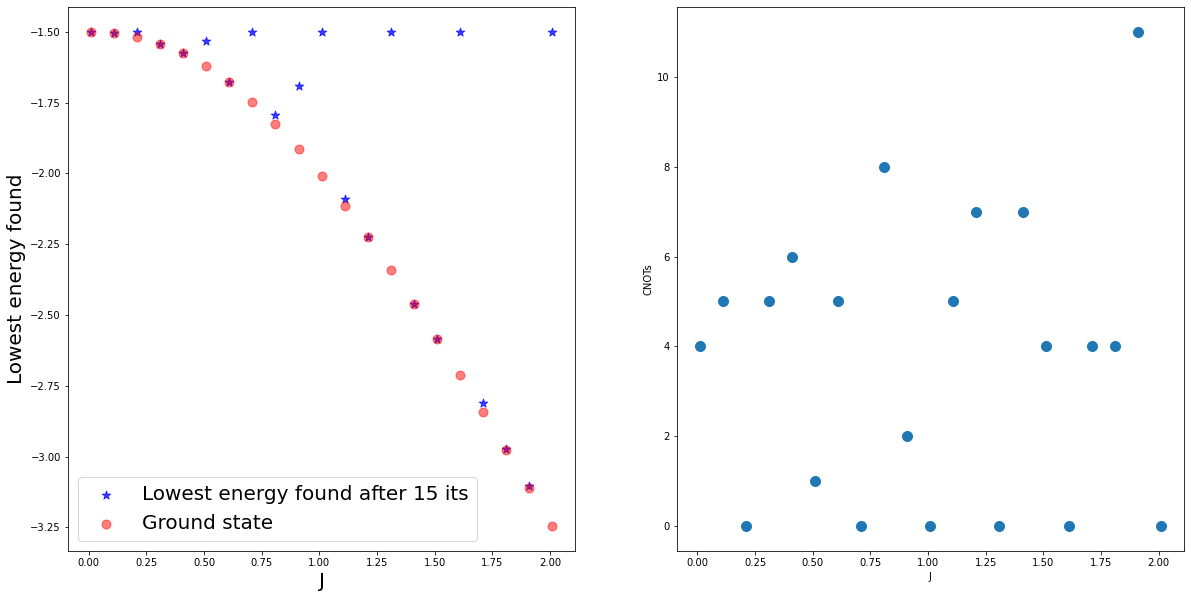

In [131]:
plt.figure(figsize=(20,10))
plt.title(r'$H = -\sum_i^{n=3} \; Z_i - \;J \sum_i^{n=3} X_i X_{i+1}$', size=25)
ax1 = plt.subplot2grid((1,2),(0,0))
ax2= plt.subplot2grid((1,2),(0,1))

ax1.set_ylabel("Lowest energy found", size=20)
ax1.set_xlabel("J", size=20)

js = np.arange(.01,2.1,.1)
ax1.scatter(js,[k.lowest_energy_found for k in sols.values()], marker="*",alpha=.75, s=80, c="blue",label="Lowest energy found after 15 its")
ax1.scatter(js,np.loadtxt("vals_comparison.csv"), alpha=.5, s=80, c="red",label="Ground state")
ax1.legend(prop={"size":20})
#plt.xticks(js, size=30)

ax2.scatter(js, [k.count_number_cnots(k.best_circuit_found) for k in sols.values()], alpha=1, s=100)
ax2.set_xlabel("J")
ax2.set_ylabel("CNOTs")

array([-1.50003769, -1.50478945, -1.51829075, -1.54162281, -1.57568938,
       -1.62108314, -1.67798339, -1.74612289, -1.82483694, -1.91317535,
       -2.01003731, -2.11429222, -2.22486606, -2.34079088, -2.4612245 ,
       -2.58545105, -2.71287073, -2.84298521, -2.97538212, -3.10972052])

In [80]:
csv.reader("vals_comparison.csv")

In [50]:
sol.give_circuit(sol.simplify_circuit(sol.best_circuit_found))[0]

(0, 0): ───Rz(th_3)───Rx(th_4)───Rz(th_5)───@───Rz(th_6)───Rx(th_7)───Rz(th_8)───@───X───Rz(th_9)───Rx(th_10)───Rz(th_11)───
                                            │                                    │   │
(0, 1): ───Rz(th_0)───Rx(th_1)───Rz(th_2)───X────────────────────────────────────X───@──────────────────────────────────────

In [48]:
sol.best_circuit_found

[3, 2, 0, 2, 3, 0, 1, 2]

Text(0.5, 0, 'iteration')

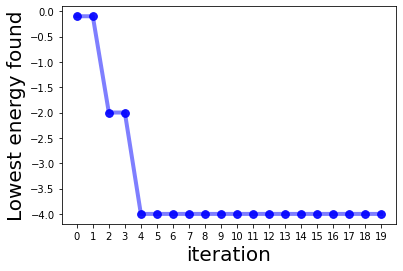

In [59]:
plt.plot(range(len(history_energies)), history_energies, linewidth=4, alpha=.5, color= "blue")
plt.scatter(range(len(history_energies)), history_energies,  s=60,alpha=.9, color= "blue", label="4 qubits")
plt.ylabel("Lowest energy found", size=20)
plt.xticks(range(len(history_energies)))
plt.xlabel("iteration", size=20)

In [72]:
hist5 = history_energies

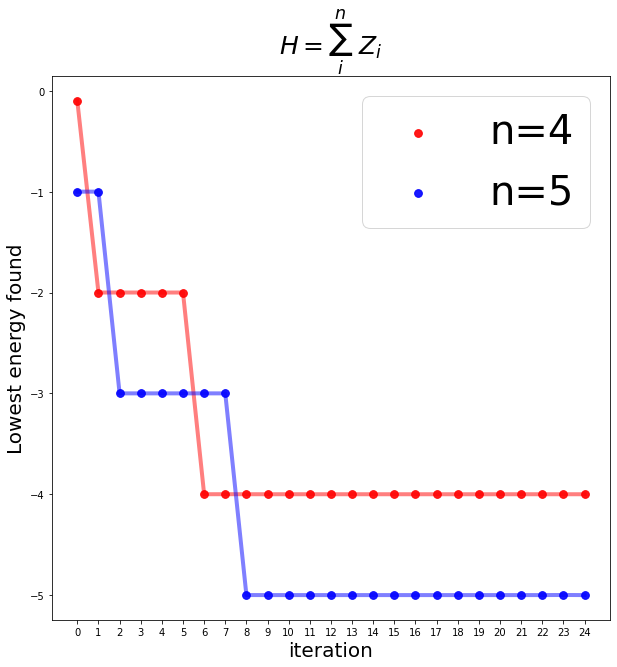

In [87]:
plt.figure(figsize=(10,10))
plt.title(r'$H = \sum_i^{n} \; Z_i$', size=25)
plt.ylabel("Lowest energy found", size=20)
plt.xticks(range(len(history_energies)))
plt.xlabel("iteration", size=20)
plt.legend(prop={"size":40})

plt.plot(range(len(history_energies)), history_energies, linewidth=4, alpha=.5, color= "red")
plt.scatter(range(len(history_energies)), history_energies,  s=60,alpha=.9, color= "red", label="n=4")
plt.plot(range(len(hist5)), hist5, linewidth=4, alpha=.5, color= "blue")
plt.scatter(range(len(history_energies)), hist5,  s=60,alpha=.9, color= "blue", label="n=5")
plt.ylabel("Lowest energy found", size=20)
plt.xticks(range(len(history_energies)))
plt.xlabel("iteration", size=20)
plt.legend(prop={"size":40})
plt.savefig("preliminar_diagonal_ising.png")

<Figure size 432x288 with 0 Axes>

In [85]:
sol.give_circuit(sol.best_circuit_found)[0]

┌──┐                                               ┌──┐                                       ┌──┐
(0, 0): ───Rz(th_0)────Rx(th_1)────Rz(th_2)────X───Rz(th_12)───Rx(th_13)───Rz(th_14)────────────────────────────@─────Rz(th_18)───Rx(th_19)───Rz(th_20)───@────────X─────Rz(th_24)───Rx(th_25)───Rz(th_26)────X─────Rz(th_33)───Rx(th_34)───Rz(th_35)───
                                               │                                                                │                                         │        │                                          │
(0, 1): ───Rz(th_15)───Rx(th_16)───Rz(th_17)───┼────────────────────────────────────────────────────────────────┼X────────────────────────────────────────┼────────┼X────Rz(th_30)───Rx(th_31)───Rz(th_32)────┼X────────────────────────────────────────
                                               │                                                                ││                                        │        ││                                         ││
(0, 2): ───Rz(th_3)────Rx(th_4)────Rz(th_5)────┼───@───────────X───────────Rz(th_9)────Rx(th_10)───Rz(th_11)────┼@────────────────────────────────────────┼───X────@┼────Rz(th_21)───Rx(th_22)───Rz(th_23)────@┼────────────────────────────────────────
                                               │   │           │                                                │                                         │   │     │                                          │
(0, 3): ───────────────────────────────────────@───X───────────@───────────Rz(th_6)────Rx(th_7)────Rz(th_8)─────X─────────────────────────────────────────X───@─────@────Rz(th_27)───Rx(th_28)───Rz(th_29)─────@────────────────────────────────────────
                                                                                                               └──┘                                               └──┘                                       └──┘